## Simulate a MA(2) process and make forecast

Simulate a stationary MA(2) process. To do so, use the `ArmaProcess` function from the statsmodels library and simulate the following process:

`yt = 0.9θt–1 + 0.3θt–2`

1. For this exercise, generate 1,000 samples.

```
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
np.random.seed(42)    
ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, 0, 0])

# Set the seed for reproducibility. Change the seed if you want to experiment with different values.
MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)
```

2. Plot your simulated moving average.
3. Run the ADF test, and check if the process is stationary.
4. Plot the ACF, and see if there are significant coefficients after lag 2.
5. Separate your simulated series into train and test sets. Take the first 800 time steps for the train set, and assign the rest to the test set.
6. Make forecasts over the test set. Use the mean, last value, and an MA(2) model. Make sure you repeatedly forecast 2 timesteps at a time using the recursive_forecast function we defined.
7. Plot your forecasts.
8. Measure the MAE, and identify your champion model.
9. Plot your MAEs in a bar plot.

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess

from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error

In [4]:
import numpy as np
np.random.seed(42)    
ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, 0, 0])

# Set the seed for reproducibility. Change the seed if you want to experiment with different values.
MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

MA2_process.shape

(1000,)

In [5]:
df = pd.DataFrame({'values': MA2_process})

In [6]:
df.head()

,values
0,0.496714
1,0.308778
2,0.672265
3,2.064470
4,1.330880


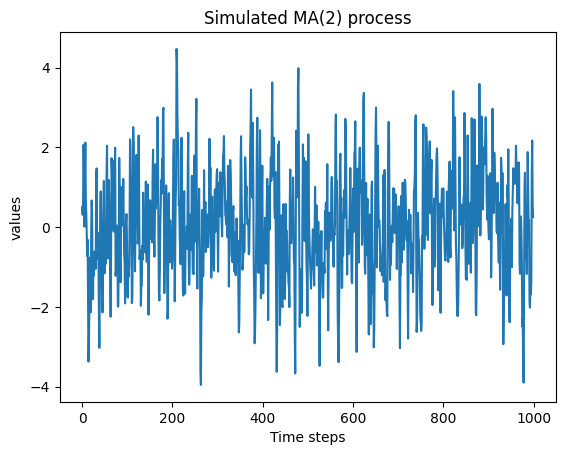

In [9]:
# Plot the series

plt.plot(df, label='series')
plt.title('Simulated MA(2) process')
plt.xlabel('Time steps')
plt.ylabel('values')
plt.show()

In [10]:
# Check for stationarity

adf_result = adfuller(df)
print(f'ADF score: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF score: -14.005444309194491
p-value: 3.795601616713556e-26


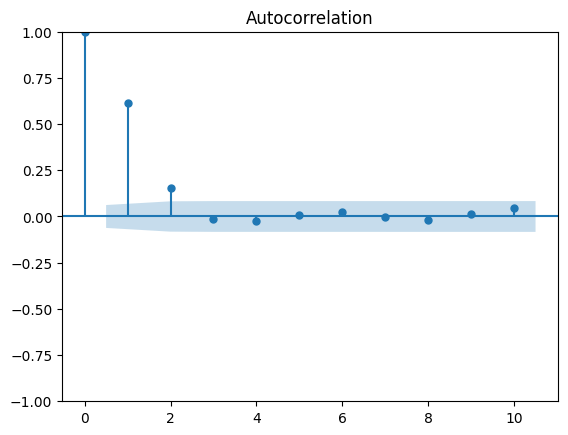

In [11]:
# Plot ACF

plot_acf(df, lags=10)
plt.show()

The series is stationary with an autocorrelation upto 2 lags, hence, it is a Moving Average Process of order 2, i.e. MA(2).

In [12]:
# Creating train and test sets
train = df[:800]
test = df[800:]
train.head()

,values
0,0.496714
1,0.308778
2,0.672265
3,2.064470
4,1.330880


In [13]:
test.head()

,values
800,0.973560
801,0.337338
802,-0.086834
803,-0.530580
804,-0.821708


In [14]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str):
    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'MA':
        pred_MA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order = (0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i+window-1)
            cos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(cos_pred)

        return pred_MA

In [16]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

In [17]:
pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ma = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

In [18]:
test.loc[:,'pred_mean'] = pred_mean
test.loc[:, 'pred_last'] = pred_last
test.loc[:,'pred_MA'] = pred_ma
test.head()

C:\Users\Divya Tiwari\AppData\Local\Temp\ipykernel_5128\3463730421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'pred_mean'] = pred_mean
C:\Users\Divya Tiwari\AppData\Local\Temp\ipykernel_5128\3463730421.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last'] = pred_last
C:\Users\Divya Tiwari\AppData\Local\Temp\ipykernel_5128\3463730421.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,values,pred_mean,pred_last,pred_MA
800,0.973560,-0.017430,0.259693,0.065366
801,0.337338,-0.017430,0.259693,0.017984
802,-0.086834,-0.015752,0.337338,-0.180397
803,-0.530580,-0.015752,0.337338,-0.116820
804,-0.821708,-0.016481,-0.530580,-0.405768


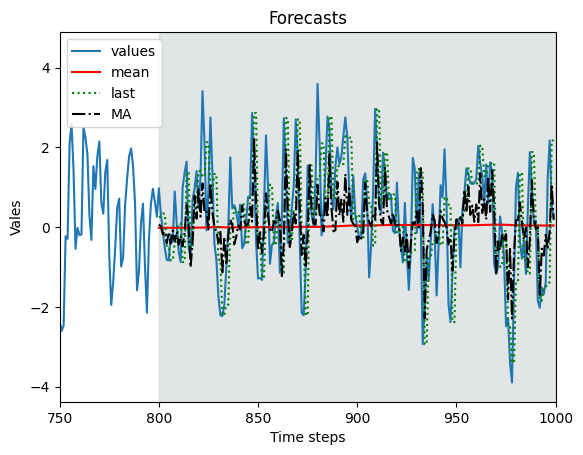

In [28]:
# Plotting the predictions

plt.plot(df, label='values')
plt.plot(test['pred_mean'], 'r-', label='mean')
plt.plot(test['pred_last'], 'g:', label='last')
plt.plot(test['pred_MA'], 'k-.', label='MA')

plt.legend(loc=2)

plt.title('Forecasts')
plt.xlabel('Time steps')
plt.ylabel('Vales')
plt.axvspan(800, 1000, color='#708080', alpha=0.2)
plt.xlim(750, 1000)
plt.show()

In [29]:
# Measure model performance
mae_mean = mean_absolute_error(test['values'], test['pred_mean'])
mae_last = mean_absolute_error(test['values'], test['pred_last'])
mae_ma = mean_absolute_error(test['values'], test['pred_MA'])
print(mae_mean, mae_last, mae_ma)

1.1010264556229208 1.084792824383183 0.8578051936574382


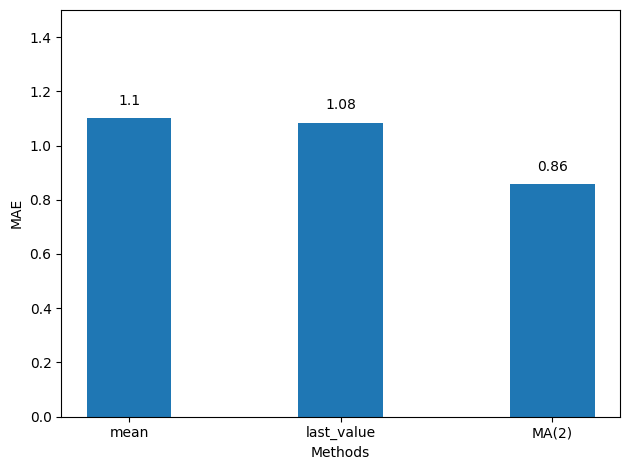

In [35]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mae_mean, mae_last, mae_ma]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MAE')
ax.set_ylim(0, 1.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.05, s=str(round(value, 2)), ha='center')

plt.tight_layout()